<a href="https://colab.research.google.com/github/santyxd3000/Undergraduate-Project/blob/main/Classifying_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO DE GRADO - MODELOS DE CLASIFICACIÓN**

Santiago Pardo Morales - 202013025

In [1]:
#For using the GPU
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 910.00 KiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 980.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import datetime
import scipy
sns.set()
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import io
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import cudf
import cuml
import cupy as cp
from cuml import preprocessing as cpp
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
physical_devices = tf.config.list_physical_devices('GPU')
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import NearMiss
from cuml.svm import SVC
from cuml.multiclass import OneVsOneClassifier
from cuml.multiclass import OneVsRestClassifier

In [3]:
from collections import Counter

In [4]:
print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [6]:
#Leer datos etiquetados
df = pd.read_csv('df_with_labels.csv',sep=';').dropna()

In [7]:
#Counting each item
print(sorted(Counter(df['Label']).items()))

[('No Fault', 102869), ('Open Circuit', 167), ('Shading', 47256), ('Short Circuit', 84), ('Unknown', 22)]


In [8]:
#Time series
train_data = df[df['Timestamp']<='2021-09-03']
print(sorted(Counter(train_data['Label']).items()))

[('No Fault', 94035), ('Open Circuit', 167), ('Shading', 7948), ('Short Circuit', 64), ('Unknown', 22)]


In [9]:
val_test_data = df[df['Timestamp']>='2021-09-03']

In [14]:
#Time series
val_data = val_test_data[val_test_data['Timestamp']<='2022-05-16']
print(sorted(Counter(val_data['Label']).items()))

[('No Fault', 212), ('Shading', 23751)]


In [12]:
#Time series
test_data = val_test_data[val_test_data['Timestamp']>='2022-05-16']
print(sorted(Counter(test_data['Label']).items()))

[('No Fault', 8622), ('Shading', 15557), ('Short Circuit', 20)]


## **MÉTODO 1 - RED NEURONAL**

In [13]:
df['Label'].replace({'No Fault': 0, 'Shading': 1, 'Open Circuit': 2, 'Short Circuit': 3, 'Unknown':4}, inplace=True)

In [15]:
df[df['Label']==1].shape

(47256, 6)

In [16]:
x_data = df[['U_DC1','U_DC2','I_DC1','I_DC2']]
y_data = df[['Label']]

In [17]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)
y_data = np.array(y_data)

In [18]:
#Divide data
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y_data, train_size = 0.6, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size = 0.5, random_state=42)

### Red Neuronal - Solo capa de entrada y de salida

In [19]:
ann_1 = Sequential()
ann_1.add(Dense(4, input_shape=(x_train.shape[1],),activation='relu'))

#output layer with softmax function
ann_1.add(Dense(5,activation='softmax'))

#compile model
ann_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
history= ann_1.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_1.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 17s 5ms/step - loss: 0.2580 - accuracy: 0.9461 - val_loss: 0.0831 - val_accuracy: 0.9813
Epoch 2/100
2820/2820 [==============================] - 22s 8ms/step - loss: 0.0627 - accuracy: 0.9834 - val_loss: 0.0543 - val_accuracy: 0.9843
Epoch 3/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0465 - accuracy: 0.9869 - val_loss: 0.0455 - val_accuracy: 0.9878
Epoch 4/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0400 - accuracy: 0.9893 - val_loss: 0.0415 - val_accuracy: 0.9888
Epoch 5/100
2820/2820 [==============================] - 10s 3ms/step - loss: 0.0363 - accuracy: 0.9905 - val_loss: 0.0387 - val_accuracy: 0.9906
Epoch 6/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0339 - accuracy: 0.9914 - val_loss: 0.0373 - val_accuracy: 0.9912
Epoch 7/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0326 - accuracy: 0.9917 - val_loss: 0.0362 -

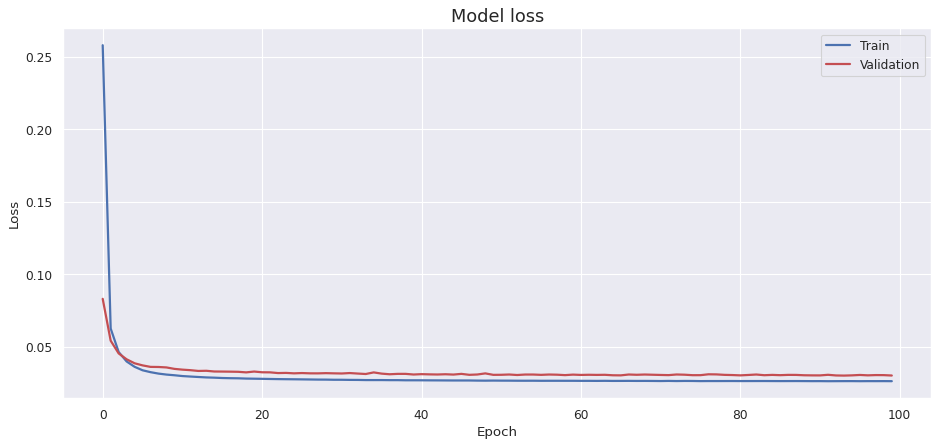

In [21]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Red Neuronal - Capa intermedia entre entrada y salida

In [22]:
ann_2 = Sequential()
ann_2.add(Dense(16, input_shape=(x_train.shape[1],),activation='relu'))
ann_2.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_2.add(Dense(5,activation='softmax'))

#compile model
ann_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
history= ann_2.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_2.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 13s 4ms/step - loss: 0.3752 - accuracy: 0.9038 - val_loss: 0.1184 - val_accuracy: 0.9835
Epoch 2/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0648 - accuracy: 0.9890 - val_loss: 0.0484 - val_accuracy: 0.9898
Epoch 3/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0347 - accuracy: 0.9917 - val_loss: 0.0334 - val_accuracy: 0.9912
Epoch 4/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0270 - accuracy: 0.9925 - val_loss: 0.0295 - val_accuracy: 0.9929
Epoch 5/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0249 - accuracy: 0.9932 - val_loss: 0.0288 - val_accuracy: 0.9929
Epoch 6/100
2820/2820 [==============================] - 13s 4ms/step - loss: 0.0238 - accuracy: 0.9937 - val_loss: 0.0275 - val_accuracy: 0.9924
Epoch 7/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0229 - accuracy: 0.9938 - val_loss: 0.0261 -

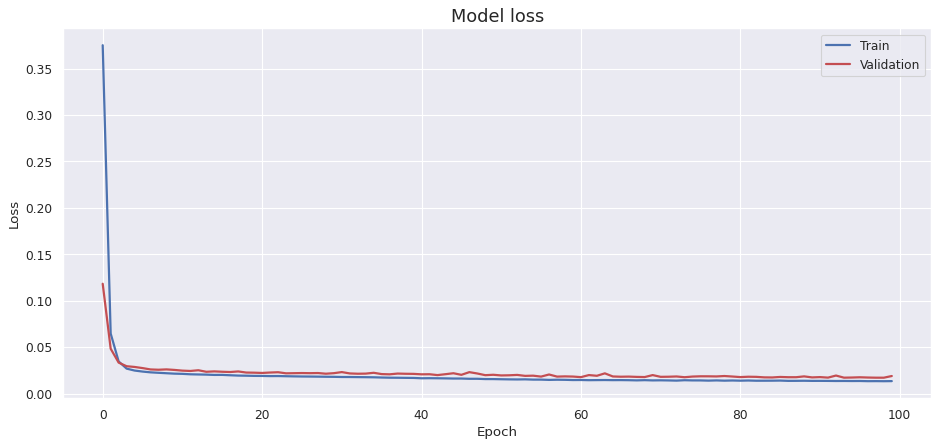

In [24]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Red Neuronal - 2 capas intermedia entre entrada y salida

In [25]:
ann_3 = Sequential()
ann_3.add(Dense(64, input_shape=(x_train.shape[1],),activation='relu'))
ann_3.add(Dense(16 ,activation='relu'))
ann_3.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_3.add(Dense(5,activation='softmax'))

#compile model
ann_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [26]:
history= ann_3.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_3.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 14s 4ms/step - loss: 0.0954 - accuracy: 0.9695 - val_loss: 0.0396 - val_accuracy: 0.9905
Epoch 2/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0288 - accuracy: 0.9920 - val_loss: 0.0319 - val_accuracy: 0.9909
Epoch 3/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0257 - accuracy: 0.9925 - val_loss: 0.0270 - val_accuracy: 0.9916
Epoch 4/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0226 - val_accuracy: 0.9923
Epoch 5/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.0201 - val_accuracy: 0.9930
Epoch 6/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0189 - accuracy: 0.9935 - val_loss: 0.0197 - val_accuracy: 0.9935
Epoch 7/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0170 - accuracy: 0.9943 - val_loss: 0.0167 -

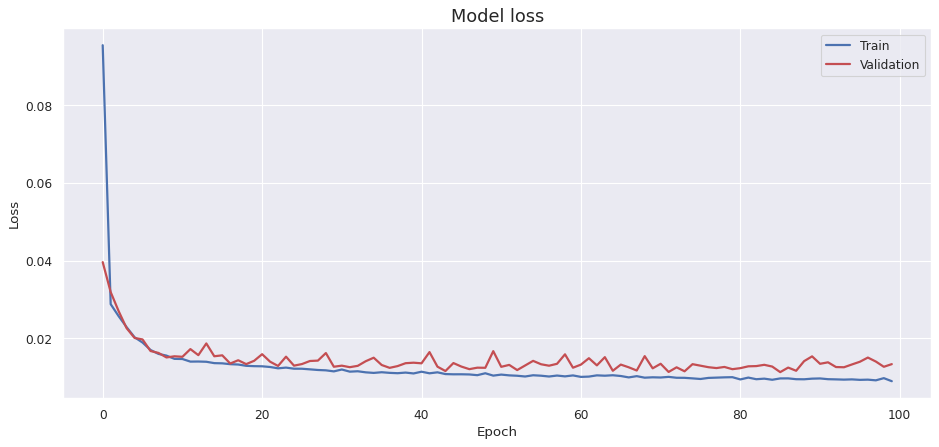

In [27]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Red Neuronal - 3 capas intermedia entre entrada y salida

In [28]:
ann_4 = Sequential()
ann_4.add(Dense(256, input_shape=(x_train.shape[1],),activation='relu'))
ann_4.add(Dense(64 ,activation='relu'))
ann_4.add(Dense(16 ,activation='relu'))
ann_4.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_4.add(Dense(5,activation='softmax'))

#compile model
ann_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [29]:
history= ann_4.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_4.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0597 - accuracy: 0.9819 - val_loss: 0.0377 - val_accuracy: 0.9895
Epoch 2/100
2820/2820 [==============================] - 13s 5ms/step - loss: 0.0275 - accuracy: 0.9918 - val_loss: 0.0254 - val_accuracy: 0.9916
Epoch 3/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0232 - accuracy: 0.9924 - val_loss: 0.0247 - val_accuracy: 0.9905
Epoch 4/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0199 - accuracy: 0.9932 - val_loss: 0.0207 - val_accuracy: 0.9933
Epoch 5/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0186 - accuracy: 0.9937 - val_loss: 0.0191 - val_accuracy: 0.9930
Epoch 6/100
2820/2820 [==============================] - 13s 5ms/step - loss: 0.0177 - accuracy: 0.9940 - val_loss: 0.0188 - val_accuracy: 0.9937
Epoch 7/100
2820/2820 [==============================] - 13s 5ms/step - loss: 0.0166 - accuracy: 0.9944 - val_loss: 0.0164 -

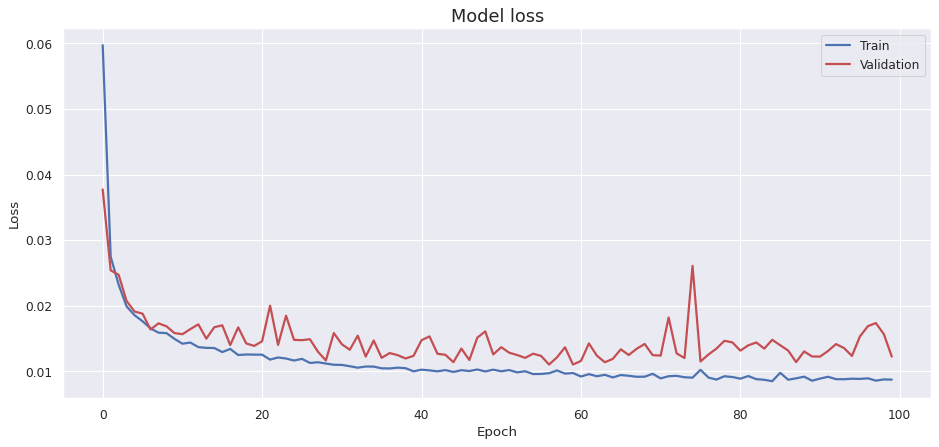

In [30]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Red Neuronal - 4 capas intermedia entre entrada y salida

In [31]:
ann_5 = Sequential()
ann_5.add(Dense(1024, input_shape=(x_train.shape[1],),activation='relu'))
ann_5.add(Dense(256 ,activation='relu'))
ann_5.add(Dense(64 ,activation='relu'))
ann_5.add(Dense(16 ,activation='relu'))
ann_5.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_5.add(Dense(5,activation='softmax'))

#compile model
ann_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [32]:
history= ann_5.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_5.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 18s 5ms/step - loss: 0.0511 - accuracy: 0.9877 - val_loss: 0.0310 - val_accuracy: 0.9906
Epoch 2/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0279 - accuracy: 0.9918 - val_loss: 0.0277 - val_accuracy: 0.9918
Epoch 3/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0234 - accuracy: 0.9925 - val_loss: 0.0234 - val_accuracy: 0.9928
Epoch 4/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.0231 - val_accuracy: 0.9929
Epoch 5/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0189 - accuracy: 0.9936 - val_loss: 0.0202 - val_accuracy: 0.9923
Epoch 6/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 0.0206 - val_accuracy: 0.9924
Epoch 7/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 0.0170 -

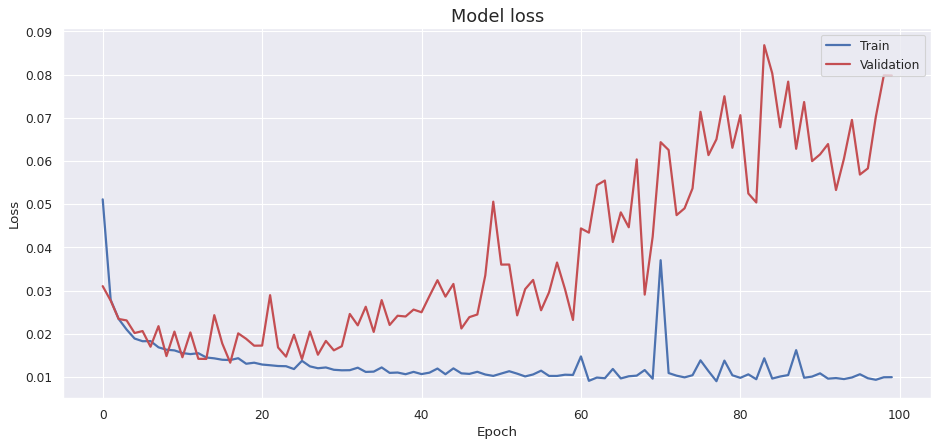

In [33]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Modelo Escogido - Red Neuronal con 2 capas intermedias entre entrada y salida

In [68]:
ann_predict_test = ann_2.predict(x_test)

940/940 [==============================] - 3s 3ms/step


In [69]:
ann_predict_test = np.argmax(ann_predict_test, axis=1)

Text(0.5, 1.0, 'Confusion Matrix for ANN - Test Data')

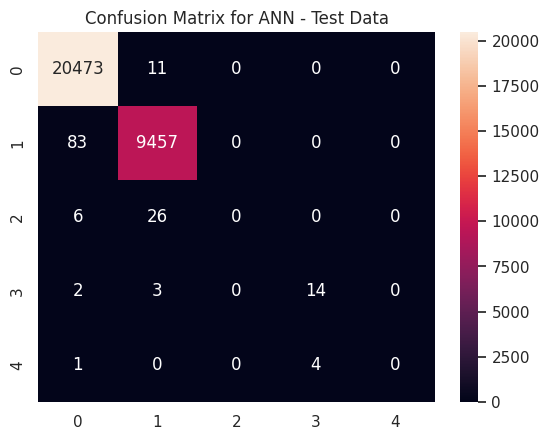

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, ann_predict_test)
sns.heatmap(cm,annot=True, fmt='g')
plt.title('Confusion Matrix for ANN - Test Data')

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, ann_predict_test)
precision = precision_score(y_test, ann_predict_test,average='macro')
recall = recall_score(y_test, ann_predict_test,average='macro')
f1_score = f1_score(y_test, ann_predict_test,average='macro')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9954787234042554
Precision: 0.5538184602347073
Recall: 0.5455209782256484
F1-Score: 0.5495572916732028


## **MÉTODO 2 - SUPPORT VECTOR MACHINES**

In [74]:
cu_df = cudf.DataFrame(df)

In [40]:
x_data = cu_df[['U_DC1','U_DC2','I_DC1','I_DC2']]
y_data = cu_df[['Label']]

In [41]:
cu_scaler = cuml.preprocessing.StandardScaler()
x_scaled = cu_scaler.fit_transform(x_data)
y_data = y_data.to_cupy()

In [42]:
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y_data, train_size = 0.6, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size = 0.5, random_state=42)

x_train = x_train.to_numpy()
y_train = y_train.ravel()
y_train = cp.asnumpy(y_train)
x_val = x_val.to_numpy()
y_val = y_val.ravel()
y_val = cp.asnumpy(y_val)
x_test = x_test.to_numpy()
y_test = y_test.ravel()
y_test = cp.asnumpy(y_test)

In [79]:
"""svc_classifier = SVC(kernel='rbf',gamma='scale',decision_function_shape='ovr',random_state=42)

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)"""

'svc_classifier = SVC(kernel=\'rbf\',gamma=\'scale\',decision_function_shape=\'ovr\',random_state=42)\n\nparam_grid = {\n    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),\n}\n\ngrid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring=\'accuracy\', cv=5, refit=\'accuracy\',n_jobs=-1)\n\ngrid_search_ovr.fit(x_train, y_train)\n\nprint("Best Parameters for SVM with One vs Rest Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)'

In [127]:
best_svm_1 = OneVsRestClassifier(SVC(kernel='rbf',gamma='scale',random_state=42,C=1000))
best_svm_1.fit(x_train,y_train)
best_svm_1_val_pred = best_svm_1.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

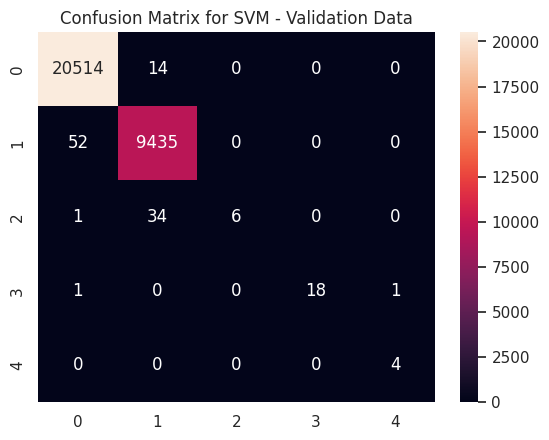

In [99]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_1_val_pred)
sns.heatmap(cm,annot=True, fmt='g')
plt.title('Confusion Matrix for SVM - Validation Data')

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_1_val_pred)
precision = precision_score(y_val, best_svm_1_val_pred,average='macro')
recall = recall_score(y_val, best_svm_1_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_1_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9965757978723404
Precision: 0.9584625746176508
Recall: 0.8080356566624005
F1-Score: 0.8169300630674432


In [ ]:
"""svc_classifier =SVC(kernel='rbf',gamma='auto',decision_function_shape='ovr',)

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification RBF Kernel and Gamma Auto: ", grid_search_ovr.best_params_)"""

In [103]:
best_svm_2 = OneVsRestClassifier(SVC(kernel='rbf',gamma='auto',random_state=42,C=1000))
best_svm_2.fit(x_train,y_train)
best_svm_2_val_pred = best_svm_2.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

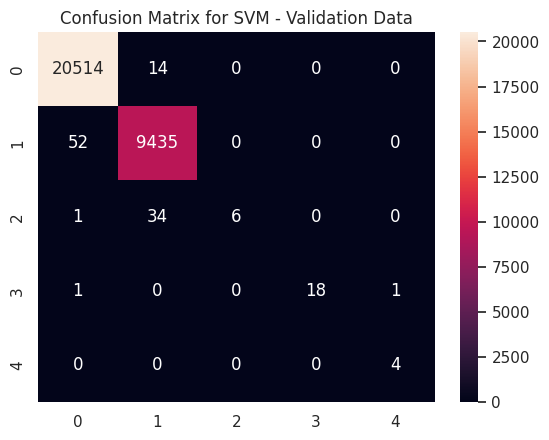

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_2_val_pred)
sns.heatmap(cm,annot=True, fmt='g')
plt.title('Confusion Matrix for SVM - Validation Data')

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_2_val_pred)
precision = precision_score(y_val, best_svm_2_val_pred,average='macro')
recall = recall_score(y_val, best_svm_2_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_2_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9965757978723404
Precision: 0.9584625746176508
Recall: 0.8080356566624005
F1-Score: 0.8169300630674432


In [ ]:
"""svc_classifier = SVC(kernel='sigmoid',random_state=42,decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and Sigmoid Kernel: ", grid_search_ovr.best_params_)"""

In [111]:
best_svm_3 = OneVsRestClassifier(SVC(kernel='sigmoid',random_state=42,C=0.001))
best_svm_3.fit(x_train,y_train)
best_svm_3_val_pred = best_svm_3.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

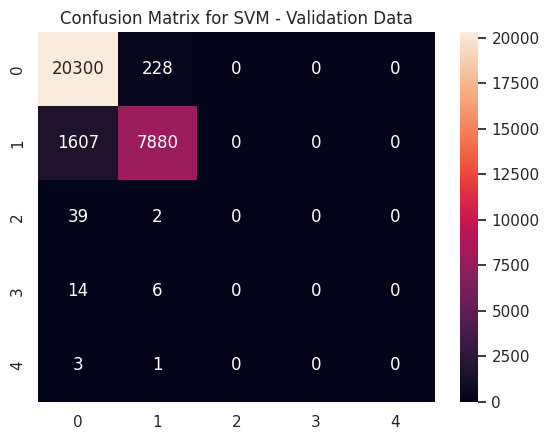

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_3_val_pred)
sns.heatmap(cm,annot=True, fmt='g')
plt.title('Confusion Matrix for SVM - Validation Data')

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_3_val_pred)
precision = precision_score(y_val, best_svm_3_val_pred,average='macro')
recall = recall_score(y_val, best_svm_3_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_3_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9368351063829787
Precision: 0.37901675340493773
Recall: 0.36390070557232146
F1-Score: 0.3701495074747267


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
"""svc_classifier = SVC(kernel='rbf',gamma='scale',random_state=42,decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)"""

In [115]:
best_svm_4 = OneVsOneClassifier(SVC(kernel='rbf',gamma='scale',random_state=42,C=1000))
best_svm_4.fit(x_train,y_train)
best_svm_4_val_pred = best_svm_4.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

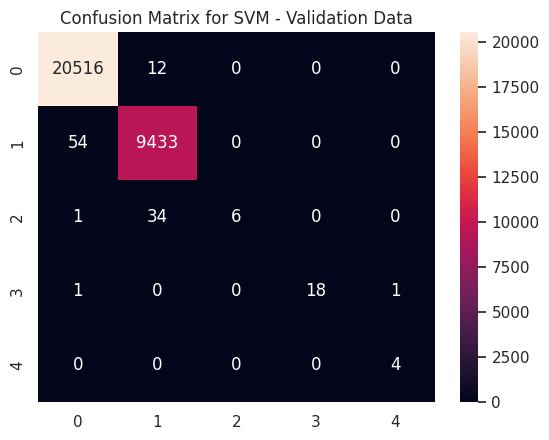

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_4_val_pred)
sns.heatmap(cm,annot=True, fmt='g')
plt.title('Confusion Matrix for SVM - Validation Data')

In [117]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_4_val_pred)
precision = precision_score(y_val, best_svm_4_val_pred,average='macro')
recall = recall_score(y_val, best_svm_4_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_4_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9965757978723404
Precision: 0.958485004163137
Recall: 0.8080129792832309
F1-Score: 0.8169298729199757


In [ ]:
"""svc_classifier = SVC(kernel='rbf',gamma='auto',random_state=42,decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification RBF Kernel and Gamma Auto: ", grid_search_ovr.best_params_)"""

In [118]:
best_svm_5 = OneVsOneClassifier(SVC(kernel='rbf',gamma='auto',random_state=42,C=1000))
best_svm_5.fit(x_train,y_train)
best_svm_5_val_pred = best_svm_5.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

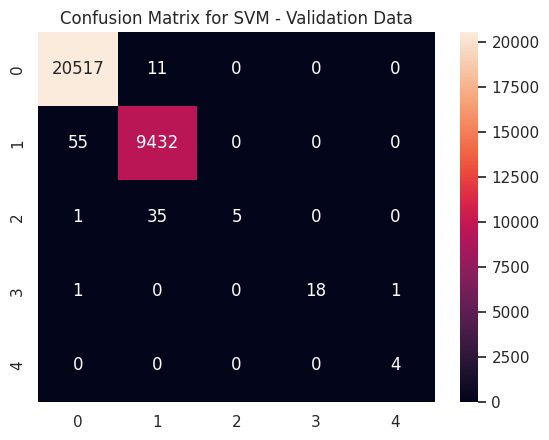

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_5_val_pred)
sns.heatmap(cm,annot=True, fmt='g')
plt.title('Confusion Matrix for SVM - Validation Data')

In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_5_val_pred)
precision = precision_score(y_val, best_svm_5_val_pred,average='macro')
recall = recall_score(y_val, best_svm_5_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_5_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9965425531914893
Precision: 0.9584752336780158
Recall: 0.8031235918131584
F1-Score: 0.8093337187581614


In [ ]:
"""svc_classifier = SVC(kernel='sigmoid',random_state=42,decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification and Sigmoid Kernel: ", grid_search_ovr.best_params_)"""

In [123]:
best_svm_6 = OneVsOneClassifier(SVC(kernel='sigmoid',random_state=42,C=0.001))
best_svm_6.fit(x_train,y_train)
best_svm_6_val_pred = best_svm_6.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

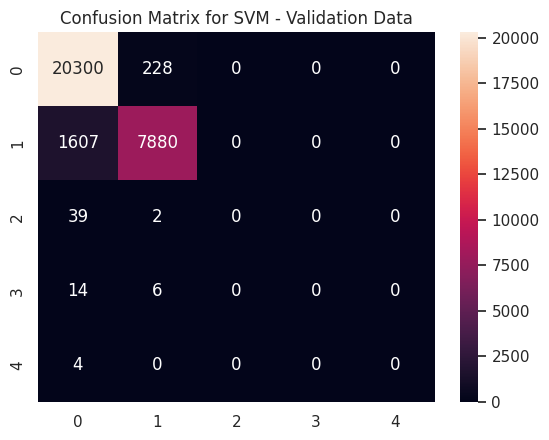

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_6_val_pred)
sns.heatmap(cm,annot=True, fmt='g')
plt.title('Confusion Matrix for SVM - Validation Data')

In [125]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_6_val_pred)
precision = precision_score(y_val, best_svm_6_val_pred,average='macro')
recall = recall_score(y_val, best_svm_6_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_6_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9368351063829787
Precision: 0.3790322602360473
Recall: 0.36390070557232146
F1-Score: 0.37015518174818396


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*Modelo Escogido - OnevsRest - Kernel RBF - Gamma Scale*

In [128]:
best_svm_1_test_pred = best_svm_1.predict(x_test)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Test Data')

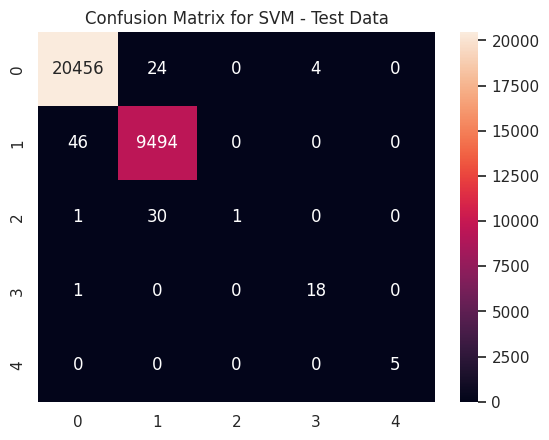

In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, best_svm_1_test_pred)
sns.heatmap(cm,annot=True, fmt='g')
plt.title('Confusion Matrix for SVM - Test Data')

In [130]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, best_svm_1_test_pred)
precision = precision_score(y_test, best_svm_1_test_pred,average='macro')
recall = recall_score(y_test, best_svm_1_test_pred,average='macro')
f1_score = f1_score(y_test, best_svm_1_test_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9964760638297873
Precision: 0.9620370353722147
Recall: 0.7944859395188572
F1-Score: 0.7863123492637107
